## Working with custom datasets

e've used some datasets in pytorch before, but how do you get you own data ubti pytorch?

One of the ways to do so, is custom datasets

## Domain libraries

Depending on what type of data you're working with, you want to use a specific library with prepared dataloaders

- torchvision
- torchtext
- torchaudio
- torchRec

In [38]:
# import pytorch and set up device agnostic code
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 dataset starts 101 different classes of food,each class with 1000 images (75/25 train/test)

Our dataset will start wit 3 classes of food and only 10% of the image data

if succesful, we could scale it for further experiments

In [39]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


In [40]:
## Exploring data, and preparing it for training
import os

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)




There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


Random image path: data\pizza_steak_sushi\test\steak\27415.jpg
Image class: steak
Image height: 384
Image width: 512


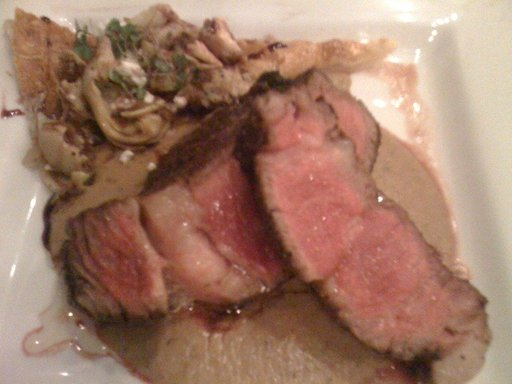

In [41]:
import random
from PIL import Image

random.seed(49) 

image_path_list = list(image_path.glob("*/*/*.jpg")) # /*/*/*.jpg means all images in all subdirectories

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 383.5, -0.5)

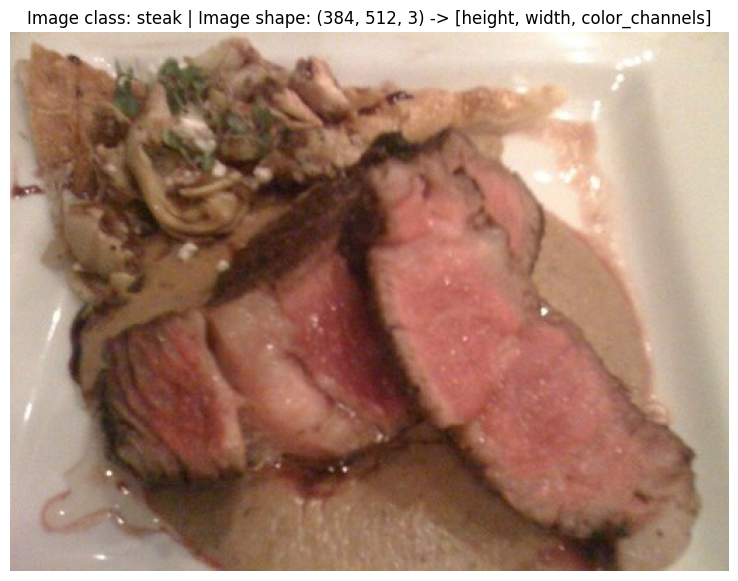

In [42]:
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

### Preparing data for modelling

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader, we'll call these Dataset and DataLoader for short.


In [43]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
  # resize our images
  transforms.Resize((64, 64)),
 # flip the images horizontally (randomly)
  transforms.RandomHorizontalFlip(),
  # convert to tensor
  transforms.ToTensor()
])


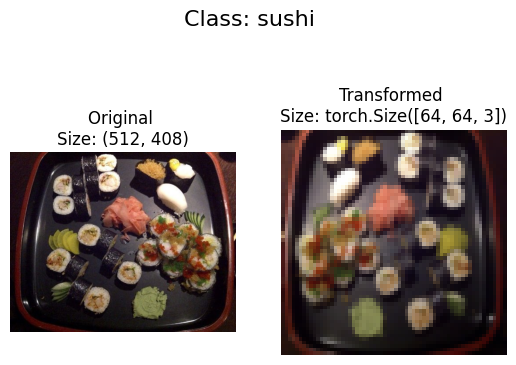

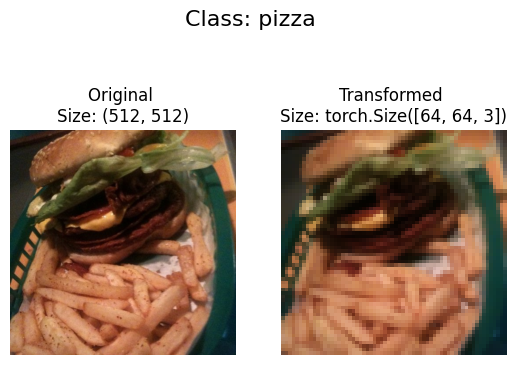

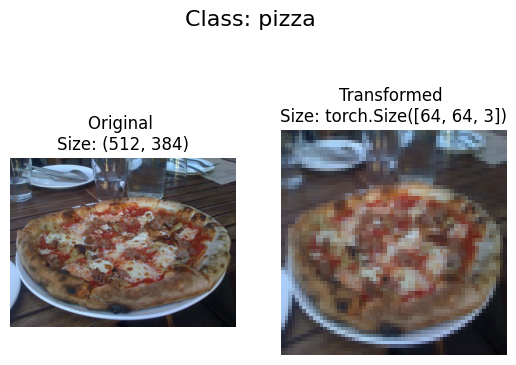

In [44]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

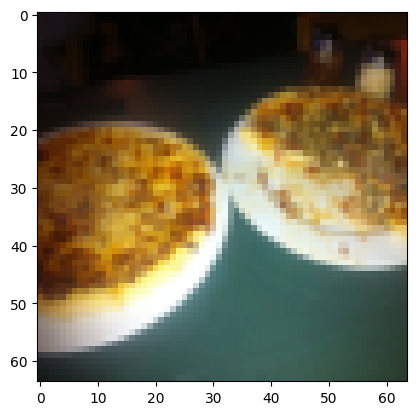

In [45]:


# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

# Loading data using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)

BATCH_SIZE = 4

train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

# Checking out the data

random.seed(43)

img, label = train_dataset[0][0], train_dataset[0][1]

plt.imshow(img.permute(1, 2, 0))

In [46]:
len(train_dataloader), len(test_dataloader)

(57, 19)

Option 2,creating own dataset loader using torch.utils.data Datasets

All custom datasets in PyTorch often subclass that class.

In [47]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

### 5.1 Creating a helper function to get class names

We want a funtion to:
1. get the class names using `os.scandir` to traverse the data directory
2. raise an error if e class names isn't found
3. turn the classnames into a dict and a list and return them

In [48]:
target_directory = train_dir
print(f'target_directory: {target_directory}')

# Get class names from the target directory

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory)) if entry.is_dir()])
print(f'class_names_found: {class_names_found}')

target_directory: data\pizza_steak_sushi\train
class_names_found: ['pizza', 'steak', 'sushi']


In [49]:
# functionize it

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = [d.name for d in os.scandir(directory) if d.is_dir()]

    if not classes:
        raise FileNotFoundError(f"Couldn't find any class directories in {directory}.")
    
    classes.sort()
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

class_names, class_to_idx = find_classes(target_directory)

print(f'class_names: {class_names}, class_to_idx: {class_to_idx}')

class_names: ['pizza', 'steak', 'sushi'], class_to_idx: {'pizza': 0, 'steak': 1, 'sushi': 2}


### 5.2 to create out own custom dataset, we want to:

1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory as a transform if we'd like to transform our data
3. Create several attributes
  * Paths
  * Transforms
  * classes
  * class_to_idx
4. Create a function to load_images()
4. Overwrite __get_item__() and __len__() methods


We need to ovewrrite the __getitem__(), supporting fetching a data sample for a given key

it can also overwrite __len__() returning the size of dataset

In [50]:
# write a custom dataset class

from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
  def __init__(self, targ_dir: str, transform=None):
    super().__init__()
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.class_names, self.class_to_idx = find_classes(targ_dir)

  def load_imade(self, index: int) -> Image.Image:
    return Image.open(self.paths[index])
  
  def __len__(self):
    return len(self.paths)
  
  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
    img = self.load_imade(idx)
    class_name = self.paths[idx].parent.name # expects path in fomat data_dir/class_name/image_name.jpg
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx

    return img, class_idx


In [51]:
train_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor()
])

test_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

In [52]:
train_data_custom = CustomImageDataset(targ_dir=train_dir, transform=train_transform)

test_data_custom = CustomImageDataset(targ_dir=test_dir, transform=test_transform)

In [53]:
print(f'train_data_custom: {len(train_data_custom)}, test_data_custom: {len(test_data_custom)}')
print(f'{len(train_dataset)} {len(train_data_custom)}')

print(f'{train_dataset.classes} {train_data_custom.class_names}')


train_data_custom: 225, test_data_custom: 75
225 225
['pizza', 'steak', 'sushi'] ['pizza', 'steak', 'sushi']


In [54]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

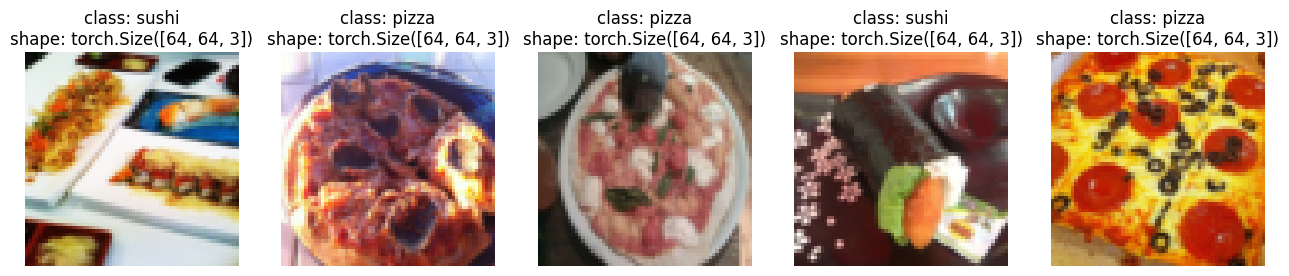

In [55]:
display_random_images(train_data_custom, classes=train_data_custom.class_names, n=5, display_shape=True, seed=42)

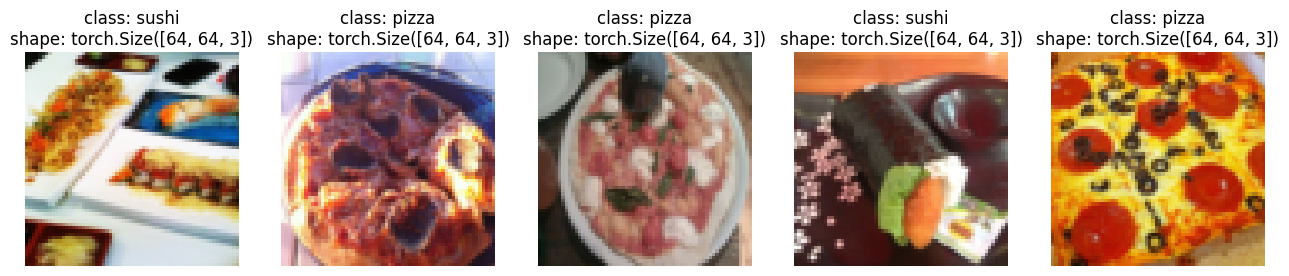

In [56]:
display_random_images(train_dataset, classes=train_dataset.classes, n=5, display_shape=True, seed=42)

In [57]:
# turn the custom dataset into a dataloader
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader_custom = torch.utils.data.DataLoader(train_data_custom, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader_custom = torch.utils.data.DataLoader(test_data_custom, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader_custom, test_dataloader_custom


(<torch.utils.data.dataloader.DataLoader at 0x1c7f30af740>,
 <torch.utils.data.dataloader.DataLoader at 0x1c7f3053560>)

In [60]:
img_custom = next(iter(train_dataloader_custom))[0]

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
